## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [2]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"




x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data
There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?
3. What about the performances of NMF, i.e. computational time and classification accuracy ?
4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

**Answer:**
1.  OK
2.  Compared to the eigenfaces obtained with PCA/ICA, the NMF-faces are way darker - which is understandable because compared to PCA/ICA we can't substract images, we can only add them - and they don't look like real face just like PCA and ICA.
3.  PCA classification made use of 233 features for a final score of 71% but was very fast. On the other hand, NMF uses less features: 100, for a better score: 87%, however it is way slower, it took nearly 30s to compute.
4.  Using PCA before NMF could reduce the total number of features which would definitely lower the final score but drastically improve computing time.

NMF uses  100  features
Percentage of correct answer using NMF is  0.8737060041407867


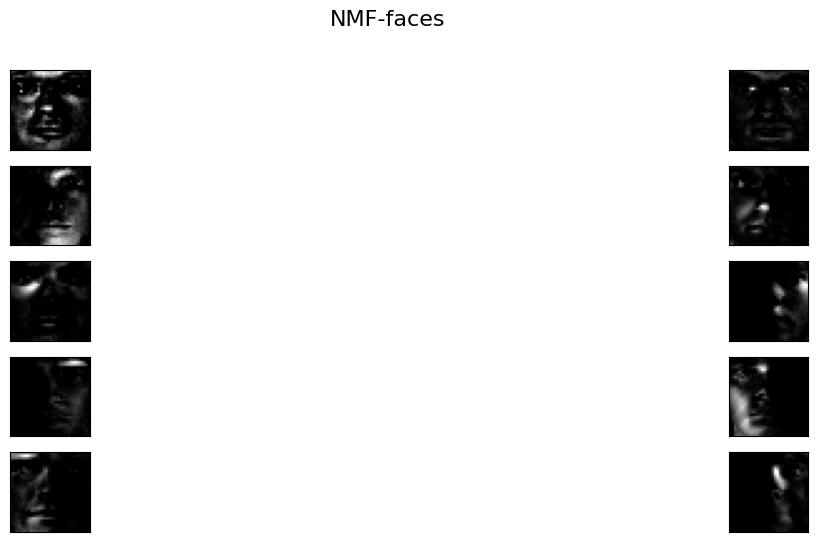

In [3]:
# NMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NMF is ', NN.score(Htest_nnmf.T,Id_Test))

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [4]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    W=np.random.rand(d,r)
    H=np.random.rand(r,N)
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
            W = np.divide(np.multiply(W,XH),np.matmul(W,HH)+eps)           
        
        H = np.divide(np.multiply(H,np.matmul(W.T,X)),np.matmul(W.T,np.matmul(W,H))+eps)

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NMF')
        plt.show()
    
    return W,H

Iteration NMF number  1  out of  300 , delta =  0.5310086501824658 , error (norm delta):  273.34035469536553
Iteration NMF number  100  out of  300 , delta =  0.15780354461470097 , error (norm delta):  81.2304598848748
Iteration NMF number  200  out of  300 , delta =  0.15044611616064268 , error (norm delta):  77.4431729874071
Iteration NMF number  300  out of  300 , delta =  0.14803247027971023 , error (norm delta):  76.20073217033871
Maximum number of iterations reached ! delta =  0.14803247027971023


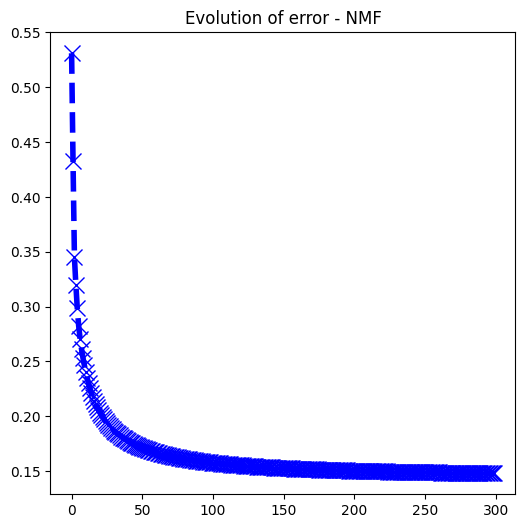

NMF uses  100  features
Percentage of correct answer using NMF is  0.8674948240165632


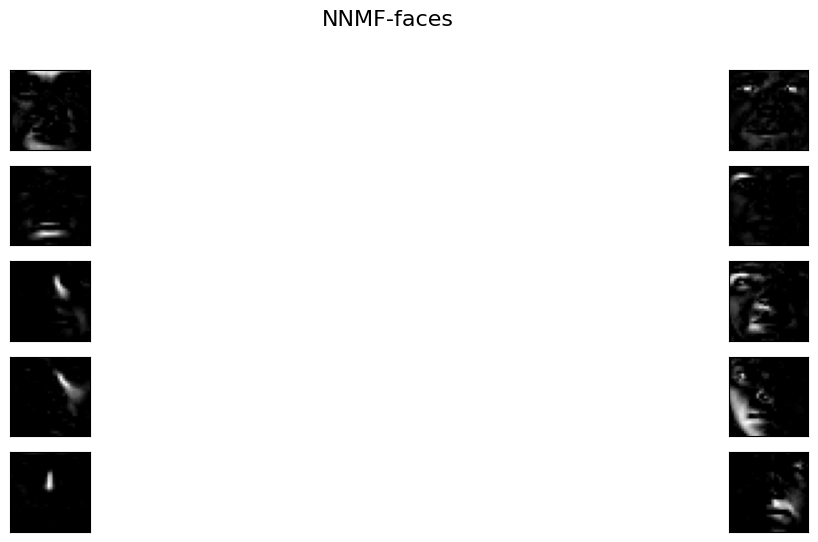

In [5]:
# NMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf),Xtest.T)

print('NMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NMF is ', NN.score(Htest_nnmf.T,Id_Test))

- What do you observe?
- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?

The NMF-faces we obtain with our implementation are different from the ones obtained with sklearn. The faces are still really dark, we get approximately the same score, althoug a little lower.\
\
Since Wtrain_nnmf is not a square matrix, it does not have an inverse thus using the Moore-Penrse inverse leads to approximations.

## I-3) ICA and NMF in the presence of noise

We will now compare ICA and NMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.
2. On the other hand, do you think that NMF behaves better? If so, for what kind of noises?

In the following, we will try to compare the behavior of ICA and NMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NMF.

3.  Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NMF are used as pre-processing steps. Comment your results.

**Answer:**
1.  If we try to get S by computing $A^{-1}(X-N)$ we might get unreadable results because of the $A^{-1}N$ term. What's more, ICA doesn't produce good results with gaussian data so a gaussian noise would be even worse.
2.  Since NMF isn't affected by data distribution, unless the noise is extremely strong it should'nt have much effect on the algorithm, gaussian noise in particular shouldn't have a stronger effect compared to other types of noise.
3.  Without noise, ICA is able to get a better accuracy than NMF but as soon as we start adding noise, the accuracy of ICA plummets while NMF's stays acceptable for a longer time.

c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8881987577639752
ICA uses  250  features
Percentage of correct answer using ICA is  0.9213250517598344
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8861283643892339
ICA uses  250  features
Percentage of correct answer using ICA is  0.8737060041407867
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8405797101449275
ICA uses  250  features
Percentage of correct answer using ICA is  0.33540372670807456
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.7743271221532091
ICA uses  250  features
Percentage of correct answer using ICA is  0.10766045548654245
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.5610766045548654
ICA uses  250  features
Percentage of correct answer using ICA is  0.07246376811594203
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.37267080745341613
ICA uses  250  features
Percentage of 

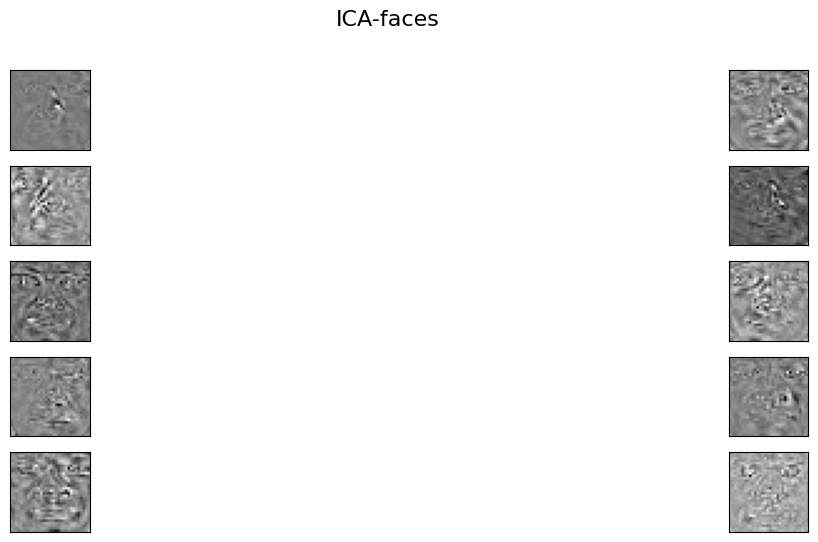

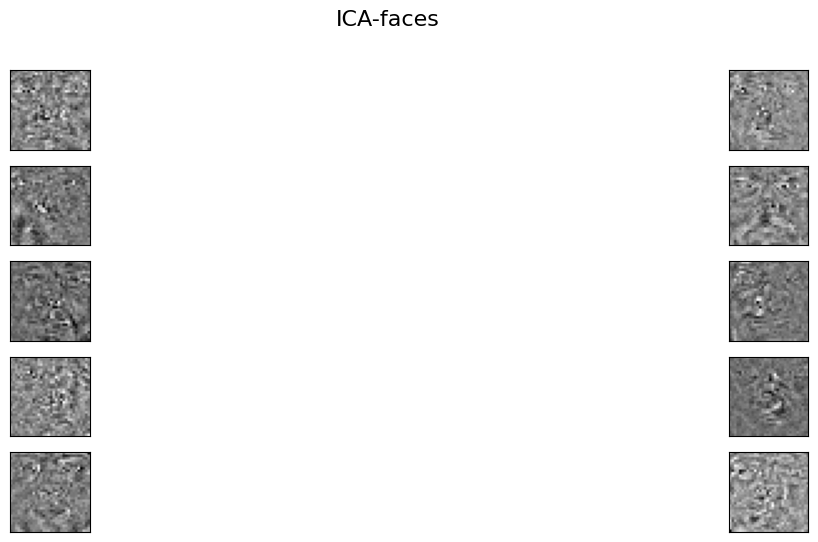

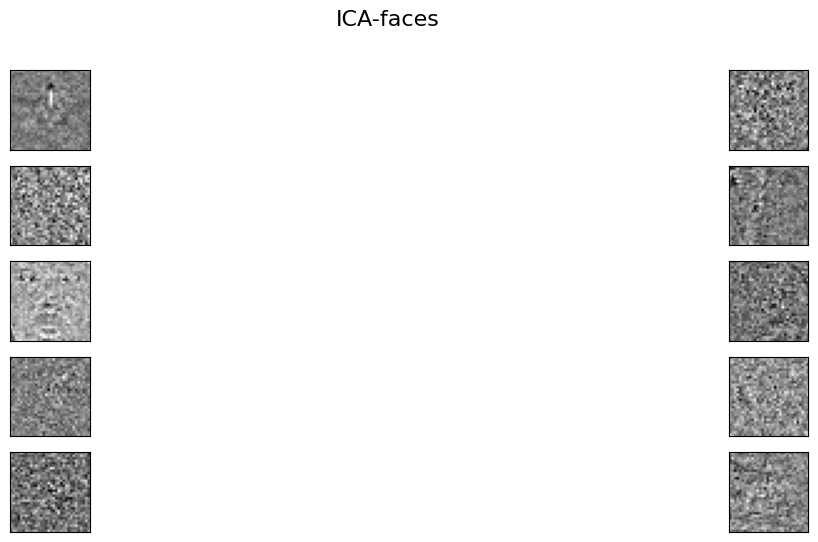

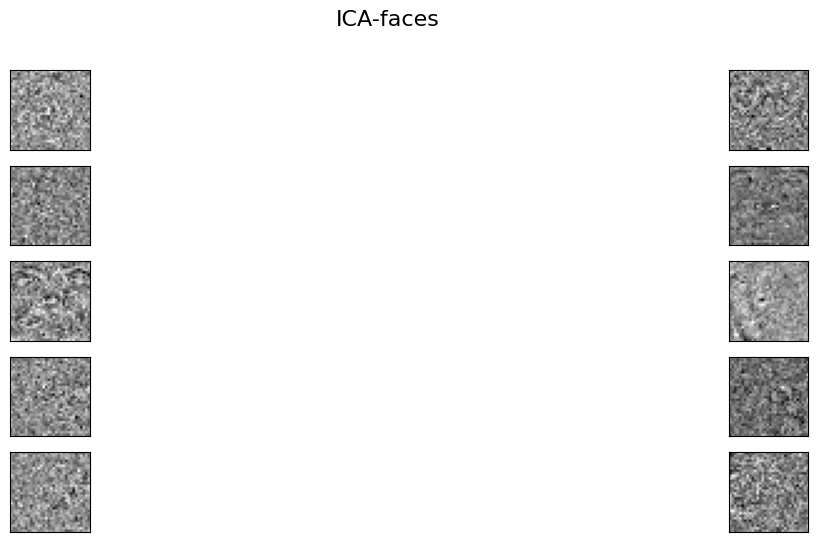

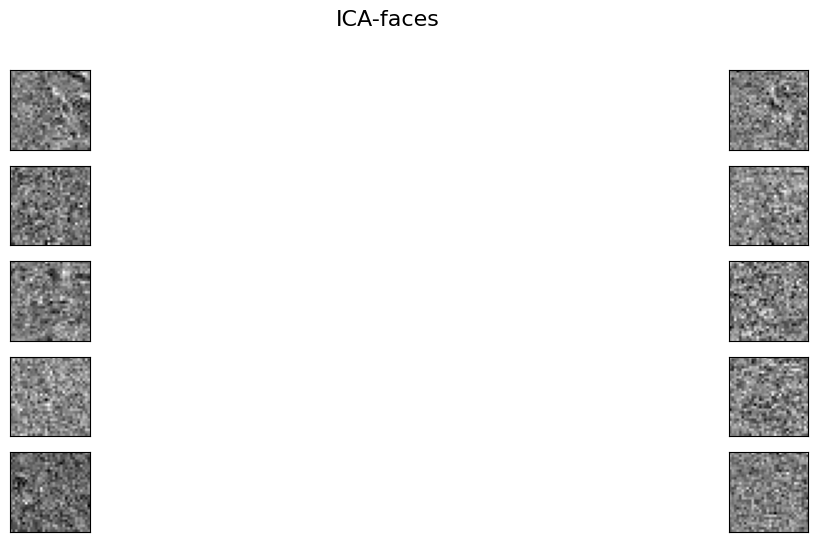

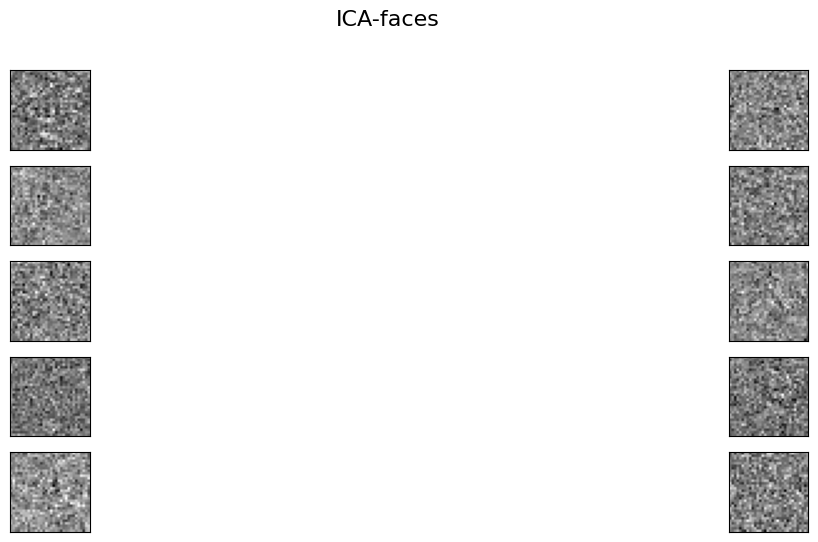

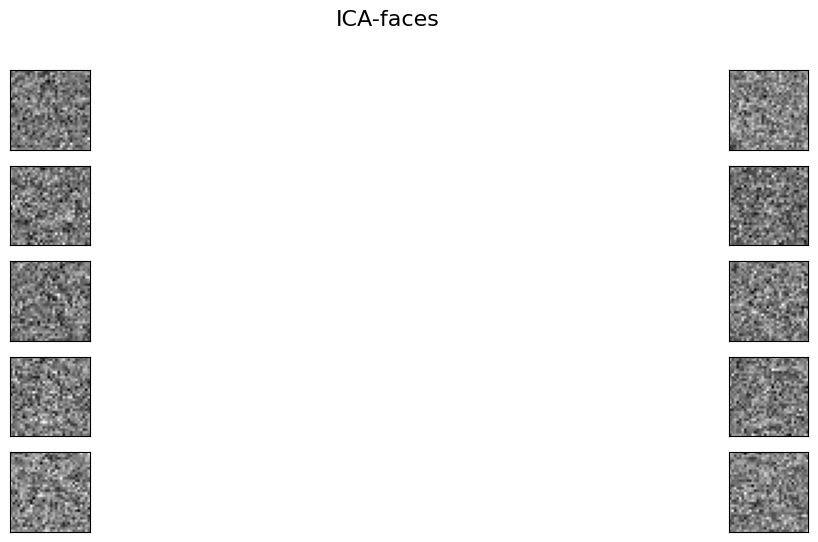

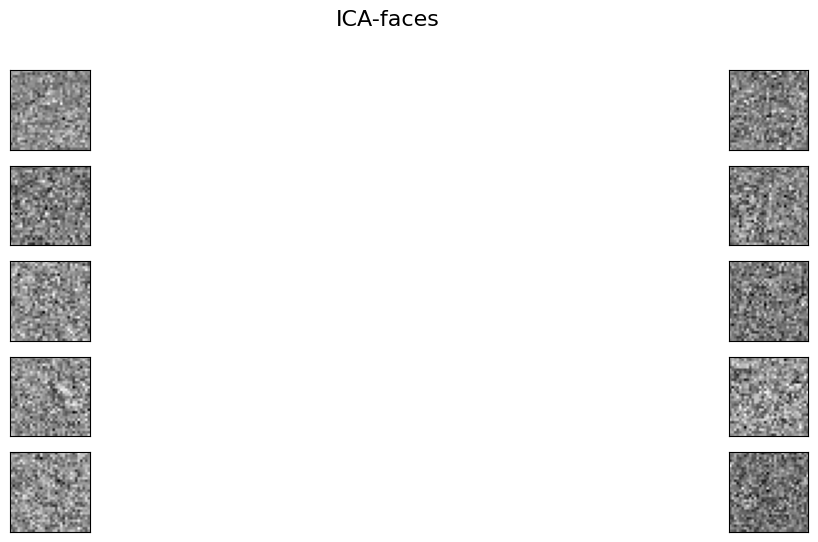

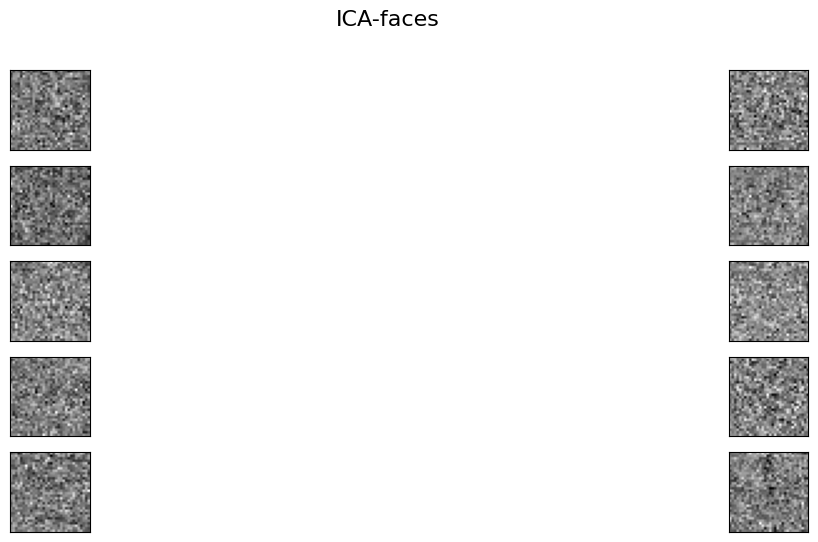

In [6]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))


for i in range(len(sigmaTab)):
    # Data generation
    XtrainNoise = Xtrain+np.random.normal(0,sigmaTab[i],Xtrain.shape)
    XtestNoise = Xtest+np.random.normal(0,sigmaTab[i],Xtest.shape)

    XtrainNoise = np.maximum(XtrainNoise,0)
    XestNoise = np.maximum(XtestNoise,0)

    ##################
    # NMF
    Ncomponents=250
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(HtrainNNMF.T,Id_Train.ravel())
    scorennmf = NN.score(Htest_nnmf.T,Id_Test)
    print('Percentage of correct answer using NNMF is ', scorennmf)
    scoreNMF[i] = scorennmf

    ##################
    ## ICA (you don't have anything to change here)
    # Second architecture (scikit-learn implementation)
    XctestNoise=XtestNoise-np.mean(XtestNoise,axis=0) # centering
    XctrainNoise=XtrainNoise-np.mean(XtrainNoise,axis=0) # centering
    
    # Second architecture (scikit-learn implementation).
    pca = PCA(random_state=1) 
    YpcaTrain=pca.fit_transform(XctrainNoise)
    UpcaTrain=pca.components_.T # we want PC on columns
    var_explained_pca=pca.explained_variance_ratio_

    # We use the PCA projection to speed up results
    PCAComp=250

    # Selection of the eigenvectors 
    Yr_train_PCA=YpcaTrain[:,:PCAComp]
    Ur_train_PCA=UpcaTrain[:,:PCAComp]
    Yr_test_PCA=np.dot(XctestNoise,Ur_train_PCA)

    ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=30000, tol=1e-4, algorithm='parallel', random_state=1)
    Yica=ICA.fit_transform(Yr_train_PCA)
    S_train_ICA=Yica.T
    W_train_ICA=ICA.components_

    ICAFAces=np.dot(Ur_train_PCA,W_train_ICA.T) 
    Y_train_ICA=S_train_ICA
    Y_test_ICA=np.dot(W_train_ICA,Yr_test_PCA.T)

    # Plot the ICA-faces
    plotFaces(ICAFAces.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA-faces')      

    print('ICA uses ', Y_train_ICA.shape[0], ' features')

    # Score ICA
    NN.fit(Y_train_ICA.T,Id_Train.ravel())
    scoreica = NN.score(Y_test_ICA.T,Id_Test.ravel())
    print('Percentage of correct answer using ICA is ', scoreica)
    scoreICA[i] = scoreica

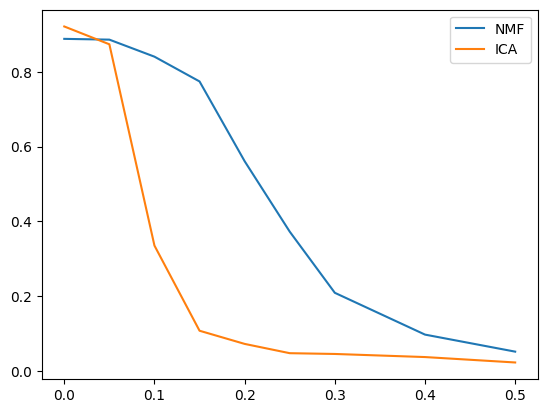

In [7]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [8]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

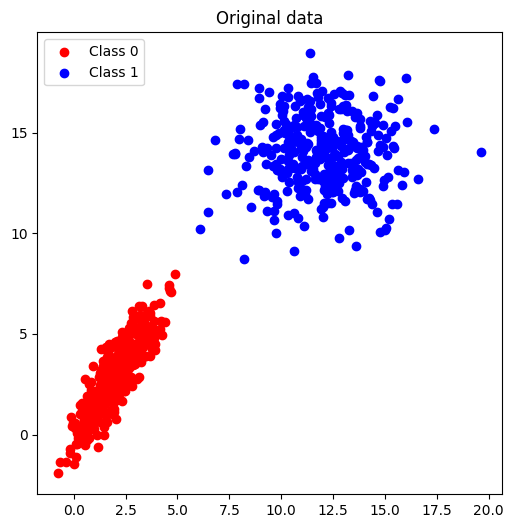

In [9]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

**Answer:**
1.  K-means clustering with two clusters works poorly on scenarios 2,3 and 4 because either the classes overlap each other or there aren't any directions that can separate them(scenario 4). As for scenario 1, every data point but 1 gets classified correctly because there is a clear separation between the two classes. In each scenario we only have two classes of data points thus it is easy to choose the correct number of clusters: 2.

c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


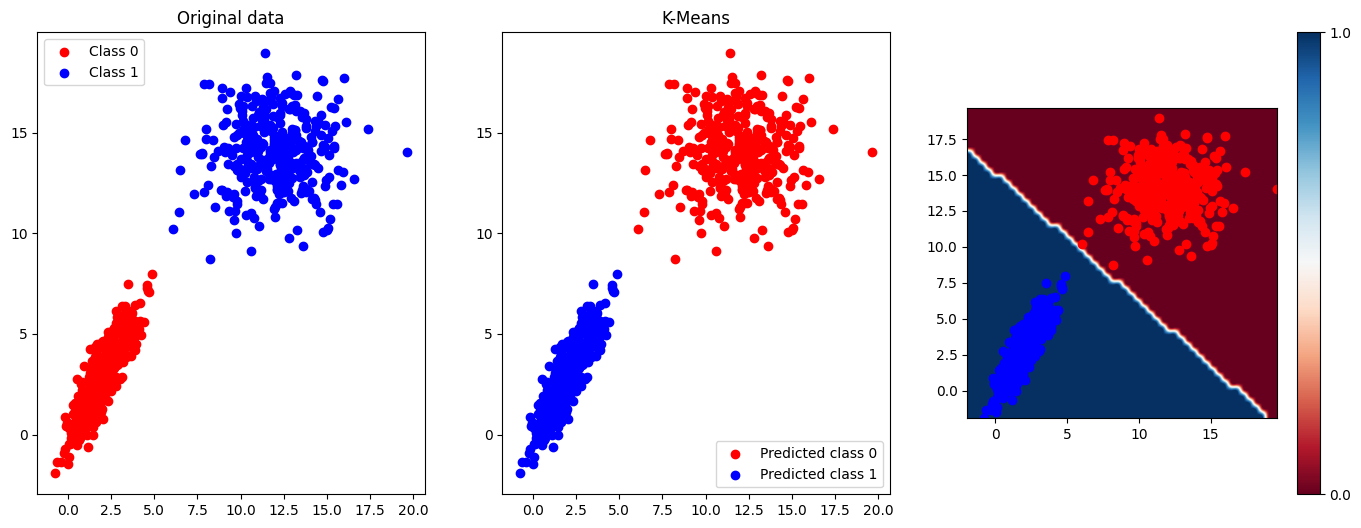

In [10]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

Now, implement your own K-means using the Lloyd's algorithm.

In [11]:
def KMeansLecture(X,K=2,tol=1e-4):
    N = X.shape[0]
    xm,ym = np.max(X,axis=0)
    muTabx = xm*np.random.rand(K)
    muTaby = ym*np.random.rand(K)
    muTab = np.concatenate((muTabx[:,None],muTaby[:,None]),axis = 1)
    yKmeans = np.zeros(N)
    previous = np.ones(N)
    while np.sum(np.abs(yKmeans-previous)) > tol:
        previous = yKmeans.copy()
        for i in range(N) :
            min = np.inf
            for j in range(K):
                d = np.linalg.norm(X[i]-muTab[j])
                #print(d)
                if d<min:
                    min = d
                    yKmeans[i] = j
        for i in range(K):
            tot = 0
            m = np.zeros(2)
            for j in range(N):
                if yKmeans[j]==i:
                    tot += 1
                    m += X[j]
            muTab[i] = 1/tot*m
    return yKmeans,muTab

Now, test your K-means algorithm.

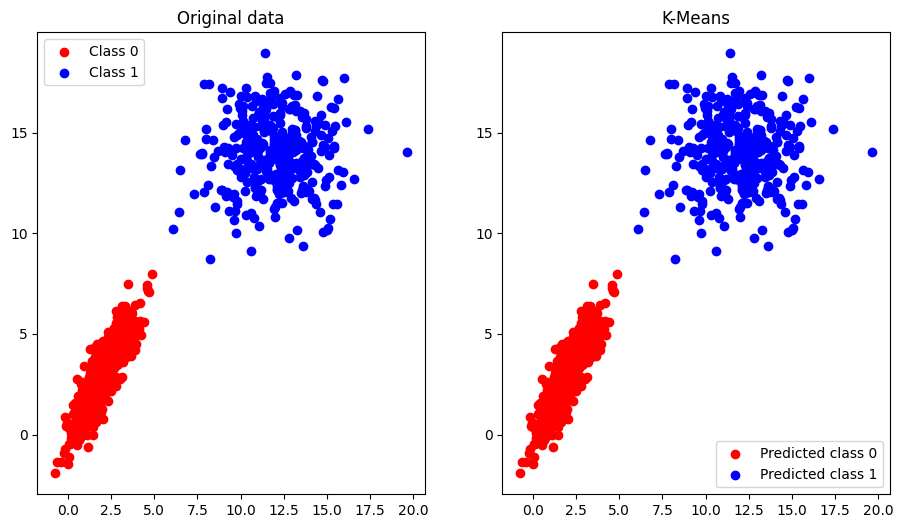

In [12]:
## K-means
Ncluster= 2 # choose a number of clusters
yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


(-0.5, 374.5, 280.5, -0.5)

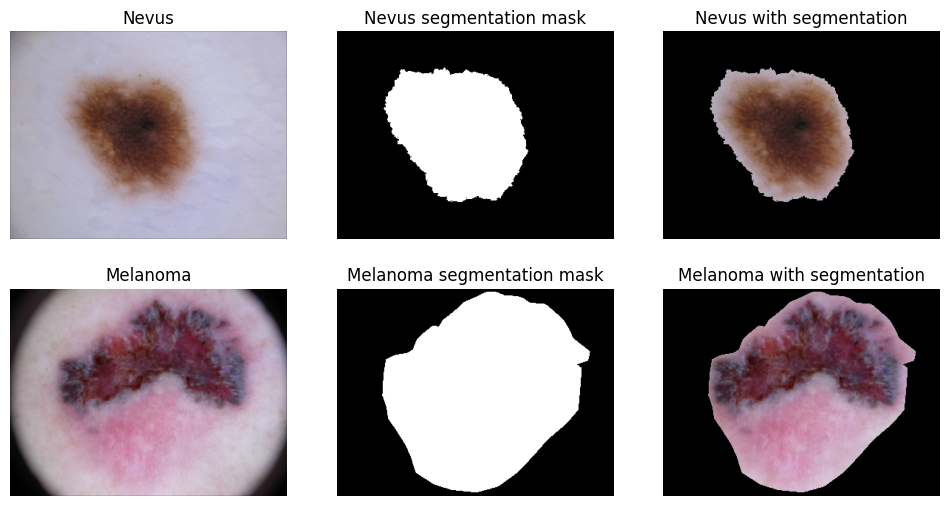

In [2]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./data/" 




# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25, channel_axis = 2,anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpeg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25, channel_axis = 2,anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

**Answer:**
1.  The nevus separates itself easily from the backgrounf so 2 clusters should be enough. The melanoma is more complicated because part of the true segmentation doesn't seem to be part of it so at least 3 clusters seem necessary.
2.  For the nevus, the worst channel is the red one since skin is a pink-ish color so the red channel is more homogenous which makes Kmeans clustering worse. However with two clusters we can't fully segment the nevus, by adding a third cluster and taking the first two we get a better segmentation.
3.  To ensure that the average of each cluster is one of the data points we can, after we compute the true average, set the closest data point as the final average of the cluster.

Dice score for the nevus and the melanoma for different number of clusters and channels:\
nev K=2:r=0.67,g=0.79,b=0.83|K=3:r=0.50,g=0.64,b=0.73\
mel K=2:r=0.50,g=0.52,b=0.52|K=3:r=0.47,g=0.30,b=0.36

c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The dice score is  0.7254395671953768


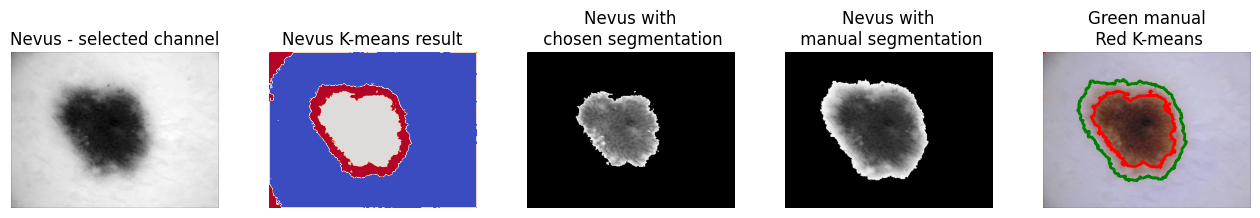

In [12]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(np.squeeze(nevusMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1))))

c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The dice score is  0.36111804014756654


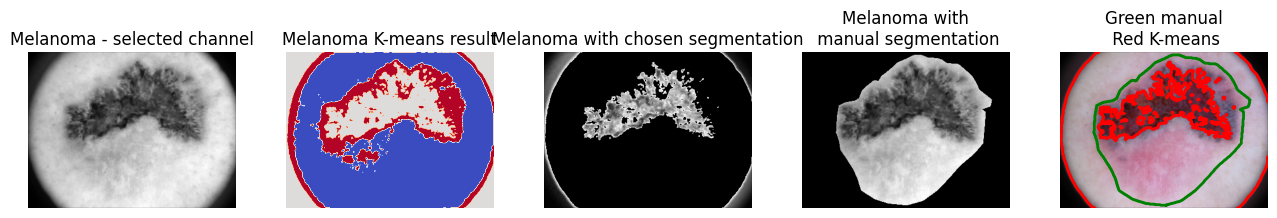

In [11]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(np.squeeze(melanomaMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1))))